<a href="https://colab.research.google.com/github/hublemon/AI_Assignment/blob/main/AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torch torchvision torchaudio numpy matplotlib seaborn scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import copy
import random
import time

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Capability: {torch.cuda.get_device_capability(0)}")

CIFAR10_CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using device: cuda
CUDA Device Name: Tesla T4
CUDA Capability: (7, 5)


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [3]:
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


transform_perturb = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


class CustomCIFAR10Dataset(Dataset):
    def __init__(self, cifar_dataset_root='./data', train=True, download=True, new_labels=None, transform=None, original_targets_source=None):
        self.cifar_dataset = torchvision.datasets.CIFAR10(root=cifar_dataset_root, train=train, download=download)
        self.transform = transform

        if original_targets_source is not None:
             self.original_targets = copy.deepcopy(original_targets_source.targets)
        else:
             self.original_targets = copy.deepcopy(self.cifar_dataset.targets)


        if new_labels is not None:
            assert len(new_labels) == len(self.cifar_dataset.targets), "New labels must match dataset size"
            self.cifar_dataset.targets = new_labels
            self.targets = new_labels
        else:
            self.targets = self.cifar_dataset.targets


    def __getitem__(self, index):
        img, target = self.cifar_dataset[index]

        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.cifar_dataset)

    def get_original_targets(self):
        return self.original_targets


def get_cifar10_loaders(batch_size=128, experiment_type="baseline", noise_level=0.2, custom_train_transform=None, data_root='./data'):
    """
    CIFAR-10 데이터 로더를 반환합니다.
    experiment_type: "baseline", "random_label_shuffle", "label_noise", "input_perturbation"
    noise_level: label_noise 실험 시 노이즈 비율
    custom_train_transform: input_perturbation 실험 시 사용할 변환
    """
    train_transform_to_use = custom_train_transform if custom_train_transform else transform_base
    test_transform_to_use = transform_base

    train_dataset_original_for_targets = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True)


    if experiment_type == "baseline":
        train_dataset = CustomCIFAR10Dataset(cifar_dataset_root=data_root, train=True, download=True, transform=train_transform_to_use)
    elif experiment_type == "random_label_shuffle":
        original_targets = np.array(train_dataset_original_for_targets.targets)
        shuffled_targets = np.random.permutation(original_targets)
        train_dataset = CustomCIFAR10Dataset(
            cifar_dataset_root=data_root, train=True, download=True,
            new_labels=shuffled_targets.tolist(), transform=train_transform_to_use,
            original_targets_source=train_dataset_original_for_targets
        )
    elif experiment_type == "label_noise":
        targets = np.array(train_dataset_original_for_targets.targets)
        num_samples = len(targets)
        num_noisy_samples = int(noise_level * num_samples)
        noisy_indices = np.random.choice(num_samples, size=num_noisy_samples, replace=False)

        new_targets = targets.copy()
        for idx in noisy_indices:
            original_label = new_targets[idx]
            possible_new_labels = [l for l in range(len(CIFAR10_CLASSES)) if l != original_label]
            new_targets[idx] = np.random.choice(possible_new_labels)
        train_dataset = CustomCIFAR10Dataset(
            cifar_dataset_root=data_root, train=True, download=True,
            new_labels=new_targets.tolist(), transform=train_transform_to_use,
            original_targets_source=train_dataset_original_for_targets
        )
    elif experiment_type == "input_perturbation":
        train_dataset = CustomCIFAR10Dataset(
            cifar_dataset_root=data_root, train=True, download=True,
            transform=train_transform_to_use
        )
    else:
        raise ValueError(f"Unknown experiment type: {experiment_type}")

    test_dataset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_transform_to_use)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True if DEVICE.type == 'cuda' else False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True if DEVICE.type == 'cuda' else False)

    return train_loader, test_loader

In [4]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=25, device=DEVICE):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        epoch_time = time.time() - start_time

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Time: {epoch_time:.2f}s")

    return epoch_losses, epoch_accuracies, epoch_times

def evaluate_model(model, test_loader, device=DEVICE, class_names=CIFAR10_CLASSES):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    class_report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    for label, metrics in class_report_dict.items():
        if label in class_names:
             print(f"  Class {label.ljust(6)}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}, Support: {metrics['support']}")
        elif label == 'accuracy':
            continue
        elif label in ['macro avg', 'weighted avg']:
             print(f"  {label.replace(' avg', '').capitalize().ljust(12)}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1-score']:.4f}, Support: {metrics['support']}")

    return avg_loss, accuracy, class_report_dict, conf_matrix, all_labels, all_preds

In [5]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title, fontsize=15)
    plt.show()

def plot_training_history(train_losses, train_accuracies, val_losses=None, val_accuracies=None, title_prefix=""):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'bo-', label='Training Loss')
    if val_losses:
        plt.plot(epochs_range, val_losses, 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Training { "and Validation " if val_losses else ""}Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'bo-', label='Training Accuracy')
    if val_accuracies:
        plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title(f'{title_prefix} Training {"and Validation " if val_accuracies else ""}Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


=============== Running Experiment: Baseline ===============


100%|██████████| 170M/170M [00:06<00:00, 24.4MB/s]


Train dataset size: 50000, Test dataset size: 10000

--- Training for Baseline ---
Epoch 1/20 - Train Loss: 1.4564, Train Acc: 0.4663, Time: 13.53s
Epoch 2/20 - Train Loss: 1.0321, Train Acc: 0.6344, Time: 13.12s
Epoch 3/20 - Train Loss: 0.8473, Train Acc: 0.7035, Time: 12.18s
Epoch 4/20 - Train Loss: 0.7339, Train Acc: 0.7437, Time: 12.54s
Epoch 5/20 - Train Loss: 0.6410, Train Acc: 0.7766, Time: 12.26s
Epoch 6/20 - Train Loss: 0.5731, Train Acc: 0.7977, Time: 13.83s
Epoch 7/20 - Train Loss: 0.5050, Train Acc: 0.8223, Time: 12.61s
Epoch 8/20 - Train Loss: 0.4439, Train Acc: 0.8423, Time: 12.52s
Epoch 9/20 - Train Loss: 0.3932, Train Acc: 0.8623, Time: 12.47s
Epoch 10/20 - Train Loss: 0.3544, Train Acc: 0.8736, Time: 12.36s
Epoch 11/20 - Train Loss: 0.3092, Train Acc: 0.8888, Time: 12.57s
Epoch 12/20 - Train Loss: 0.2745, Train Acc: 0.9004, Time: 12.48s
Epoch 13/20 - Train Loss: 0.2588, Train Acc: 0.9057, Time: 12.73s
Epoch 14/20 - Train Loss: 0.2245, Train Acc: 0.9200, Time: 12.53s
Ep

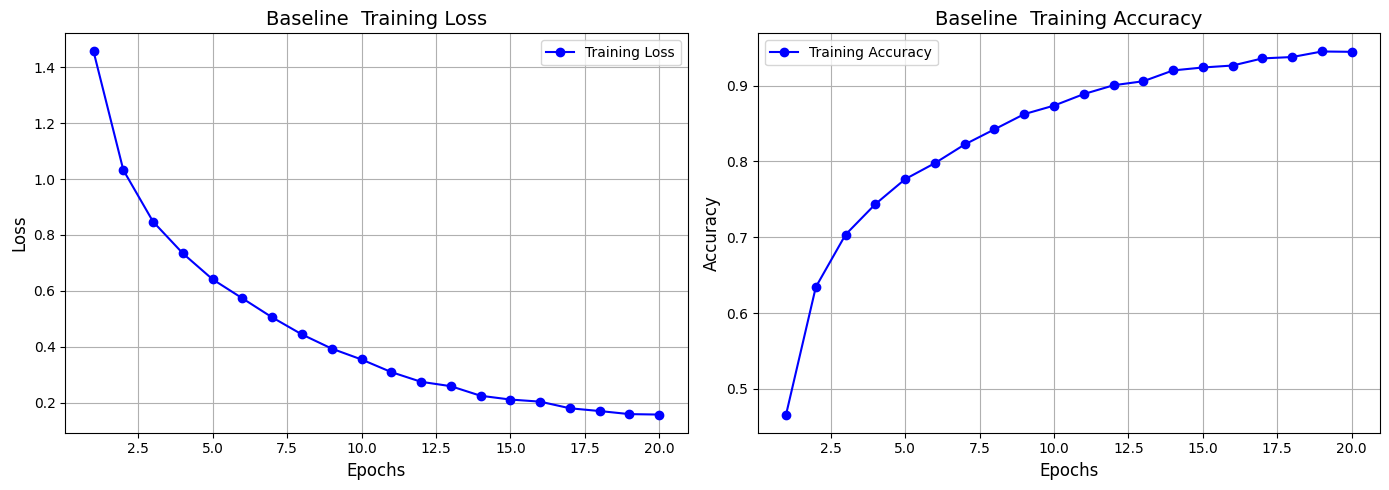

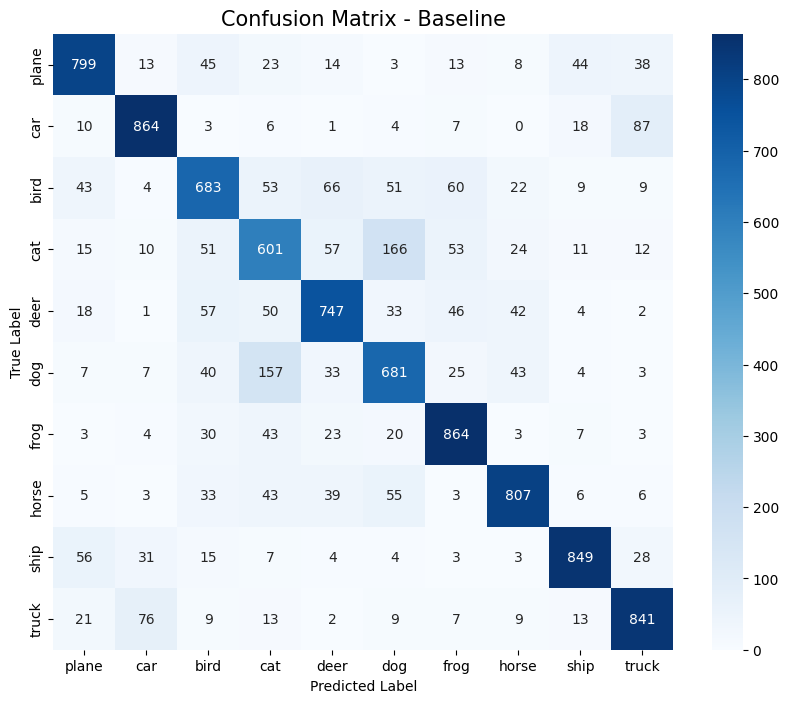



=============== Running Experiment: Random Label Shuffle ===============
Train dataset size: 50000, Test dataset size: 10000

--- Training for Random Label Shuffle ---
Epoch 1/20 - Train Loss: 2.3033, Train Acc: 0.0977, Time: 12.29s
Epoch 2/20 - Train Loss: 2.3028, Train Acc: 0.1010, Time: 12.38s
Epoch 3/20 - Train Loss: 2.3031, Train Acc: 0.1007, Time: 12.29s
Epoch 4/20 - Train Loss: 2.3028, Train Acc: 0.0995, Time: 12.35s
Epoch 5/20 - Train Loss: 2.3028, Train Acc: 0.0968, Time: 12.37s
Epoch 6/20 - Train Loss: 2.3027, Train Acc: 0.0984, Time: 12.33s
Epoch 7/20 - Train Loss: 2.3027, Train Acc: 0.0981, Time: 12.55s
Epoch 8/20 - Train Loss: 2.3027, Train Acc: 0.0974, Time: 12.44s
Epoch 9/20 - Train Loss: 2.3027, Train Acc: 0.0966, Time: 12.52s
Epoch 10/20 - Train Loss: 2.3027, Train Acc: 0.0995, Time: 12.42s
Epoch 11/20 - Train Loss: 2.3028, Train Acc: 0.0993, Time: 12.42s
Epoch 12/20 - Train Loss: 2.3028, Train Acc: 0.1012, Time: 12.26s
Epoch 13/20 - Train Loss: 2.3030, Train Acc: 0.

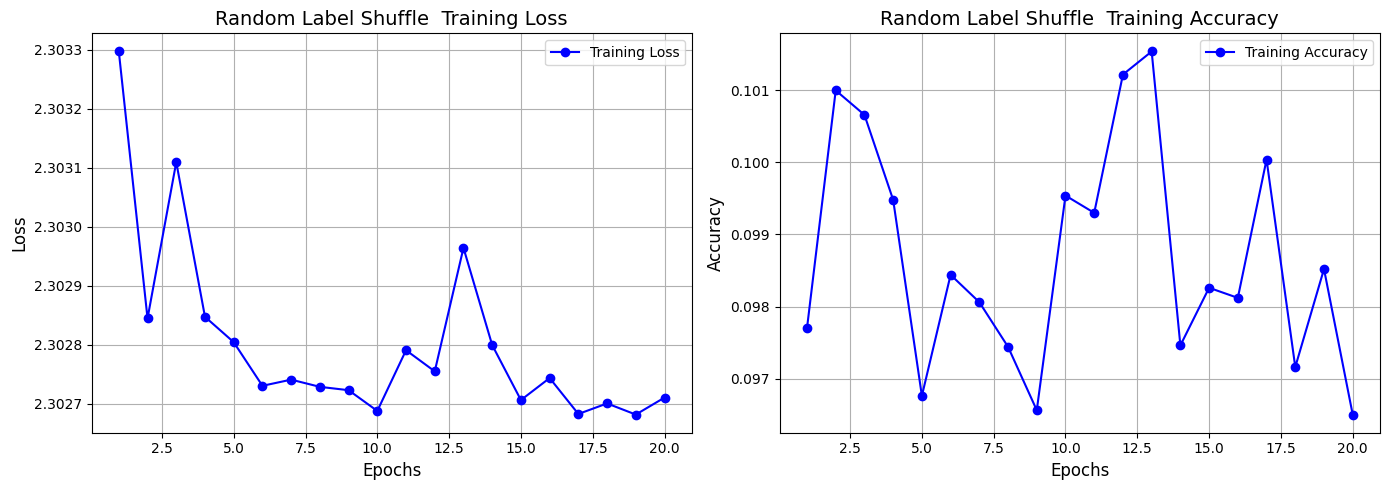

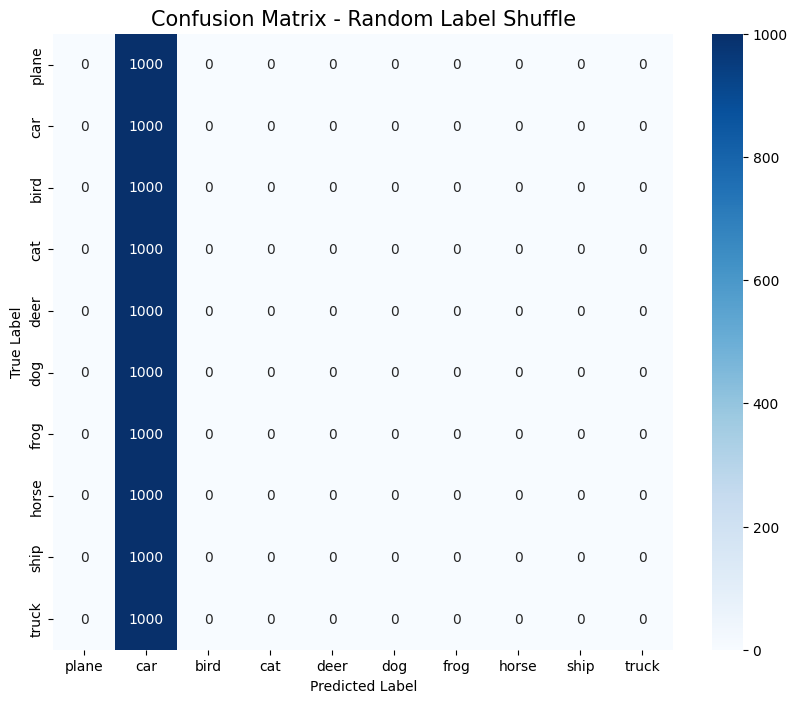



=============== Running Experiment: Label Noise (20%) ===============
Train dataset size: 50000, Test dataset size: 10000

--- Training for Label Noise (20%) ---
Epoch 1/20 - Train Loss: 1.8868, Train Acc: 0.3580, Time: 12.20s
Epoch 2/20 - Train Loss: 1.6576, Train Acc: 0.4827, Time: 12.47s
Epoch 3/20 - Train Loss: 1.5435, Train Acc: 0.5411, Time: 12.23s
Epoch 4/20 - Train Loss: 1.4651, Train Acc: 0.5731, Time: 12.38s
Epoch 5/20 - Train Loss: 1.4036, Train Acc: 0.5957, Time: 12.41s
Epoch 6/20 - Train Loss: 1.3386, Train Acc: 0.6167, Time: 12.23s
Epoch 7/20 - Train Loss: 1.2763, Train Acc: 0.6305, Time: 12.67s
Epoch 8/20 - Train Loss: 1.2128, Train Acc: 0.6483, Time: 12.30s
Epoch 9/20 - Train Loss: 1.1493, Train Acc: 0.6636, Time: 12.50s
Epoch 10/20 - Train Loss: 1.0719, Train Acc: 0.6852, Time: 12.46s
Epoch 11/20 - Train Loss: 1.0012, Train Acc: 0.6975, Time: 12.44s
Epoch 12/20 - Train Loss: 0.9277, Train Acc: 0.7179, Time: 12.49s
Epoch 13/20 - Train Loss: 0.8585, Train Acc: 0.7333, 

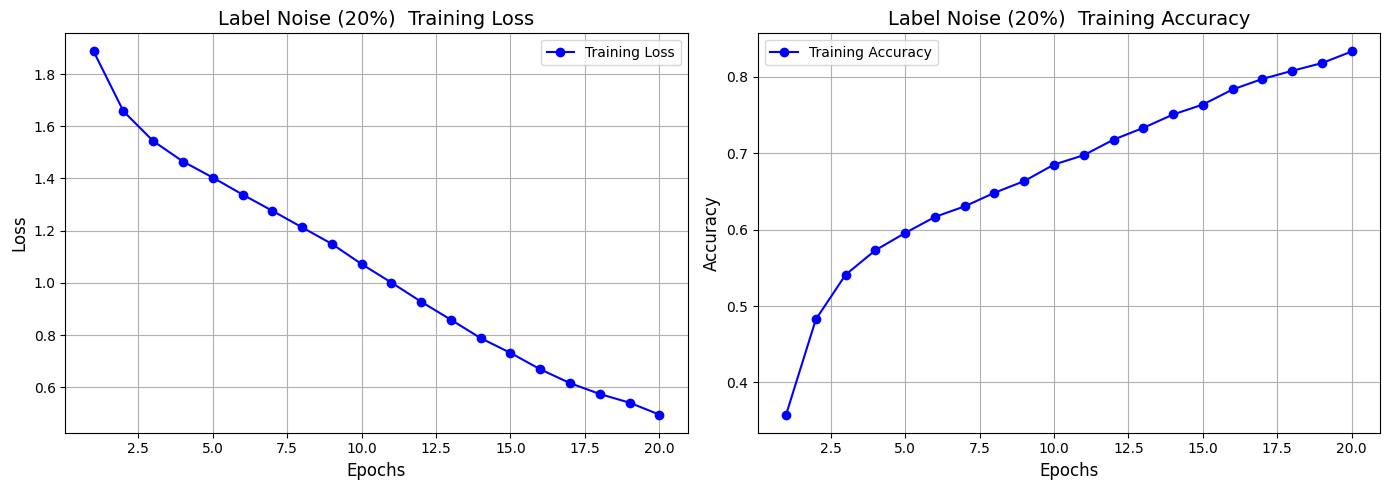

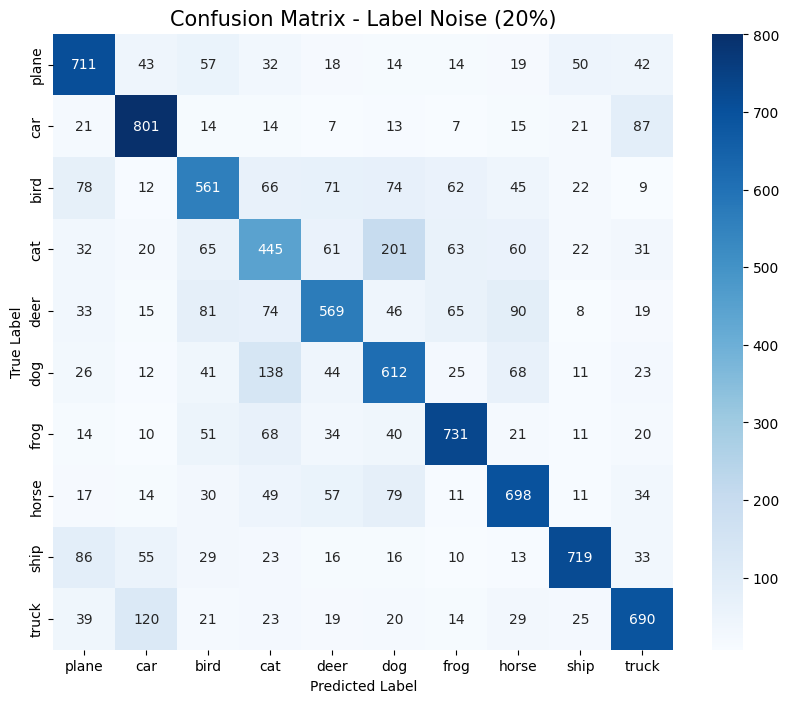



=============== Running Experiment: Input Perturbation ===============
Train dataset size: 50000, Test dataset size: 10000

--- Training for Input Perturbation ---
Epoch 1/20 - Train Loss: 1.7856, Train Acc: 0.3473, Time: 71.55s
Epoch 2/20 - Train Loss: 1.5363, Train Acc: 0.4495, Time: 71.24s
Epoch 3/20 - Train Loss: 1.4130, Train Acc: 0.4984, Time: 74.36s
Epoch 4/20 - Train Loss: 1.3305, Train Acc: 0.5265, Time: 72.05s
Epoch 5/20 - Train Loss: 1.2758, Train Acc: 0.5541, Time: 72.90s
Epoch 6/20 - Train Loss: 1.2317, Train Acc: 0.5669, Time: 72.56s
Epoch 7/20 - Train Loss: 1.1935, Train Acc: 0.5842, Time: 76.04s
Epoch 8/20 - Train Loss: 1.1653, Train Acc: 0.5931, Time: 73.42s
Epoch 9/20 - Train Loss: 1.1407, Train Acc: 0.5991, Time: 73.28s
Epoch 10/20 - Train Loss: 1.1226, Train Acc: 0.6075, Time: 71.90s
Epoch 11/20 - Train Loss: 1.1139, Train Acc: 0.6143, Time: 73.87s
Epoch 12/20 - Train Loss: 1.0866, Train Acc: 0.6198, Time: 73.65s
Epoch 13/20 - Train Loss: 1.0773, Train Acc: 0.6254

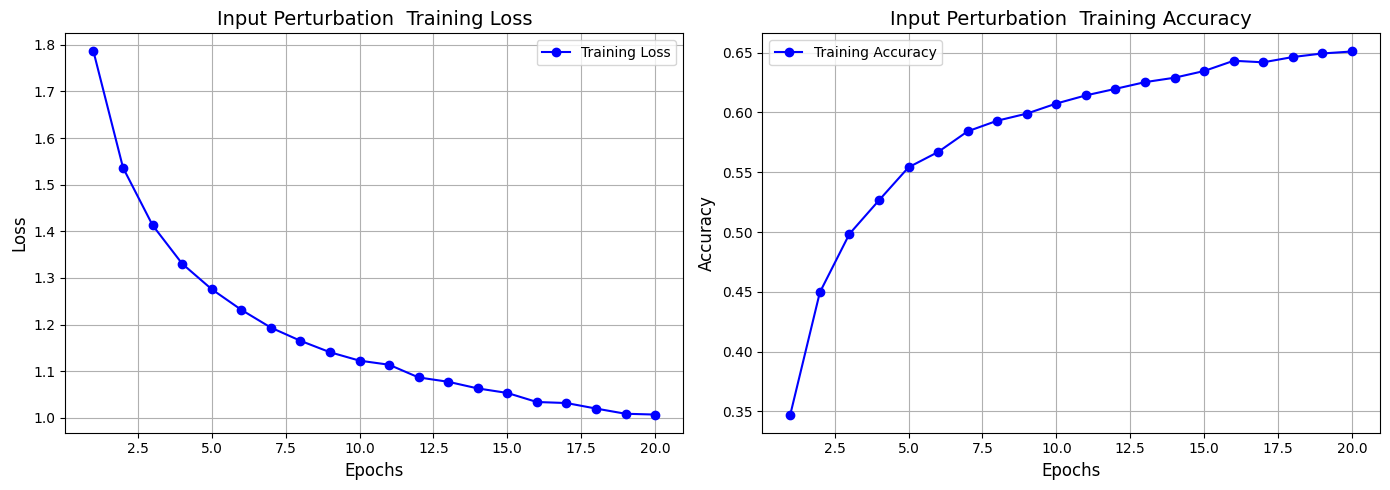

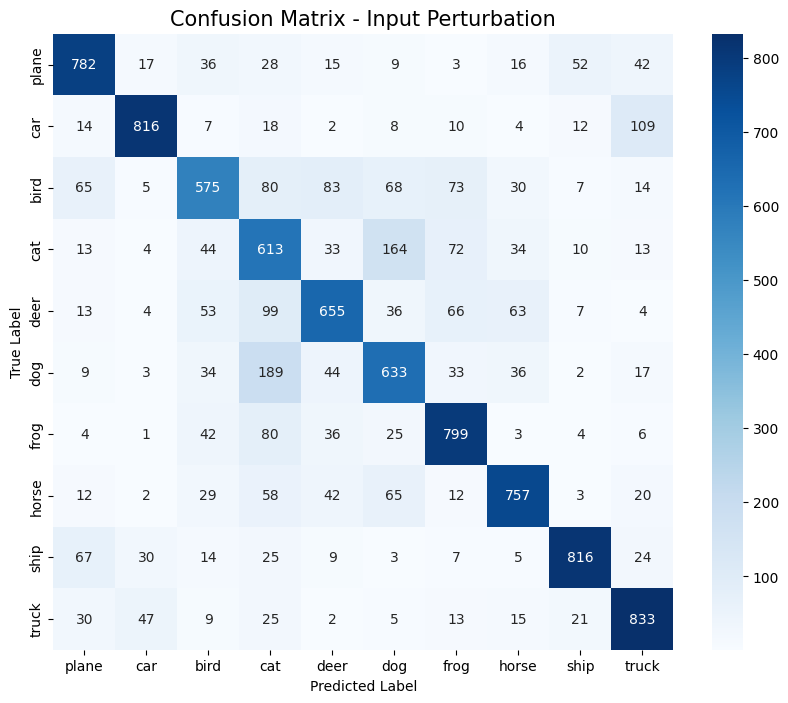




{'='*20} Overall Experiment Summary {'='*20}

Experiment: Baseline
  Final Test Accuracy: 0.7736
  Final Test Loss: 1.0514
  Weighted Avg F1-Score: 0.7735

Experiment: Random Label Shuffle
  Final Test Accuracy: 0.1000
  Final Test Loss: 2.3026
  Weighted Avg F1-Score: 0.0182

Experiment: Label Noise (20%)
  Final Test Accuracy: 0.6537
  Final Test Loss: 1.3017
  Weighted Avg F1-Score: 0.6528

Experiment: Input Perturbation
  Final Test Accuracy: 0.7279
  Final Test Loss: 0.8032
  Weighted Avg F1-Score: 0.7293


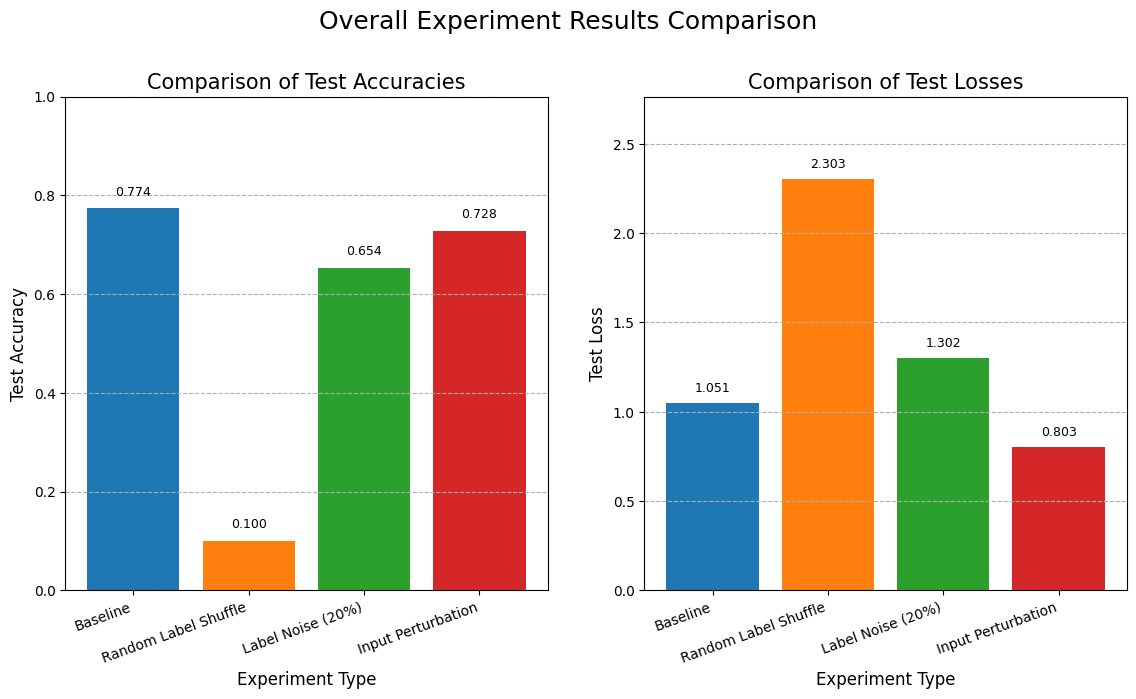


Mini-Project Code Execution Finished.


In [6]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 128
DATA_ROOT = './cifar_data'

experiment_results = {}

experiments = [
    {"name": "Baseline", "type": "baseline", "train_transform": transform_base},
    {"name": "Random Label Shuffle", "type": "random_label_shuffle", "train_transform": transform_base},
    {"name": "Label Noise (20%)", "type": "label_noise", "noise_level": 0.2, "train_transform": transform_base},
    {"name": "Input Perturbation", "type": "input_perturbation", "train_transform": transform_perturb}
]

for exp_config in experiments:
    print(f"\n{'='*15} Running Experiment: {exp_config['name']} {'='*15}")

    model = SimpleCNN(num_classes=len(CIFAR10_CLASSES)).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, test_loader = get_cifar10_loaders(
        batch_size=BATCH_SIZE,
        experiment_type=exp_config["type"],
        noise_level=exp_config.get("noise_level", 0.2),
        custom_train_transform=exp_config["train_transform"],
        data_root=DATA_ROOT
    )
    print(f"Train dataset size: {len(train_loader.dataset)}, Test dataset size: {len(test_loader.dataset)}")

    print(f"\n--- Training for {exp_config['name']} ---")
    train_losses, train_accuracies, epoch_times = train_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)
    print(f"Total training time for {exp_config['name']}: {sum(epoch_times):.2f}s")

    print(f"\n--- Evaluating for {exp_config['name']} ---")
    test_loss, test_accuracy, class_report, conf_matrix, _, _ = evaluate_model(model, test_loader, device=DEVICE, class_names=CIFAR10_CLASSES)

    experiment_results[exp_config['name']] = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "epoch_times": epoch_times,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix
    }

    plot_training_history(train_losses, train_accuracies, title_prefix=f"{exp_config['name']} ")
    plot_confusion_matrix(conf_matrix, CIFAR10_CLASSES, title=f"Confusion Matrix - {exp_config['name']}")
    print(f"{'='*50}\n")


print("\n\n{'='*20} Overall Experiment Summary {'='*20}")
for exp_name, results in experiment_results.items():
    print(f"\nExperiment: {exp_name}")
    print(f"  Final Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"  Final Test Loss: {results['test_loss']:.4f}")
    if 'weighted avg' in results['classification_report']:
        print(f"  Weighted Avg F1-Score: {results['classification_report']['weighted avg']['f1-score']:.4f}")

exp_names = list(experiment_results.keys())
test_accuracies_list = [results['test_accuracy'] for results in experiment_results.values()]
test_losses_list = [results['test_loss'] for results in experiment_results.values()]

plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
bars1 = plt.bar(exp_names, test_accuracies_list, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel("Experiment Type", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Comparison of Test Accuracies", fontsize=15)
plt.ylim(0, 1.0)
plt.xticks(rotation=20, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--')
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom', fontsize=9)


plt.subplot(1, 2, 2)
bars2 = plt.bar(exp_names, test_losses_list, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel("Experiment Type", fontsize=12)
plt.ylabel("Test Loss", fontsize=12)
plt.title("Comparison of Test Losses", fontsize=15)
min_loss = min(test_losses_list) if test_losses_list else 0
max_loss = max(test_losses_list) if test_losses_list else 1
plt.ylim(0, max(1.0, max_loss * 1.2))
plt.xticks(rotation=20, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + (max_loss*0.02 if max_loss > 0 else 0.02) , f"{yval:.3f}", ha='center', va='bottom', fontsize=9)


plt.tight_layout(pad=3.0)
plt.suptitle("Overall Experiment Results Comparison", fontsize=18, y=1.03)
plt.show()

print("\nMini-Project Code Execution Finished.")